# Module 6 – Episode 22 – Isochrones around São Bento Station (Porto, Portugal)
This notebook demonstrates how to compute and visualize **walk-time isochrones** (5, 10, 15 minutes) around Trindade Station in Porto using `OSMnx`, `NetworkX`, and `GeoPandas`.

We’ll:
1. Geocode São Bento Station (Porto, Portugal)
2. Download walkable street network from OpenStreetMap
3. Calculate travel time per segment (4 km/h)
4. Compute reachability areas (isochrones)
5. Visualize them on a map


In [1]:
!pip install osmnx geopandas contextily --quiet

In [2]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import warnings

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# 1 · Geocode Trindade Station
latlon = ox.geocode("Estação de São Bento, Porto, Portugal")
lat, lon = latlon
print("São Bento station coordinates:", latlon)

# Create point
gdf_trindade = gpd.GeoDataFrame(
    geometry=[Point(lon, lat)], crs="EPSG:4326"
).to_crs(epsg=3857)

São Bento station coordinates: (41.1454906, -8.6095146)


In [4]:
# 2 · Download walkable street network (1.5km around Trindade)
G = ox.graph_from_point(latlon, dist=1500, network_type="walk", simplify=True)

In [5]:
# 3 · Add travel time (4 km/h = 1.11 m/s)
walking_speed = 1.11
for u, v, data in G.edges(data=True):
    data["travel_time"] = data["length"] / walking_speed

In [6]:
# 4 · Find nearest network node to Trindade
orig = ox.distance.nearest_nodes(G, X=lon, Y=lat)

# Define isochrone times (in minutes)
iso_times = [5, 10, 15]
iso_polys = []

# Build polygons
for minutes in iso_times:
    subgraph = nx.ego_graph(G, orig, radius=minutes * 60, distance="travel_time")
    nodes = [Point((d["x"], d["y"])) for _, d in subgraph.nodes(data=True)]
    poly = Polygon(gpd.GeoSeries(nodes).unary_union.convex_hull)
    iso_polys.append(poly)

# Convert to GeoDataFrame
gdf_iso = gpd.GeoDataFrame({"time": iso_times, "geometry": iso_polys}, crs="EPSG:4326").to_crs(epsg=3857)

# Edges for map background
_, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges = gdf_edges.to_crs(epsg=3857)

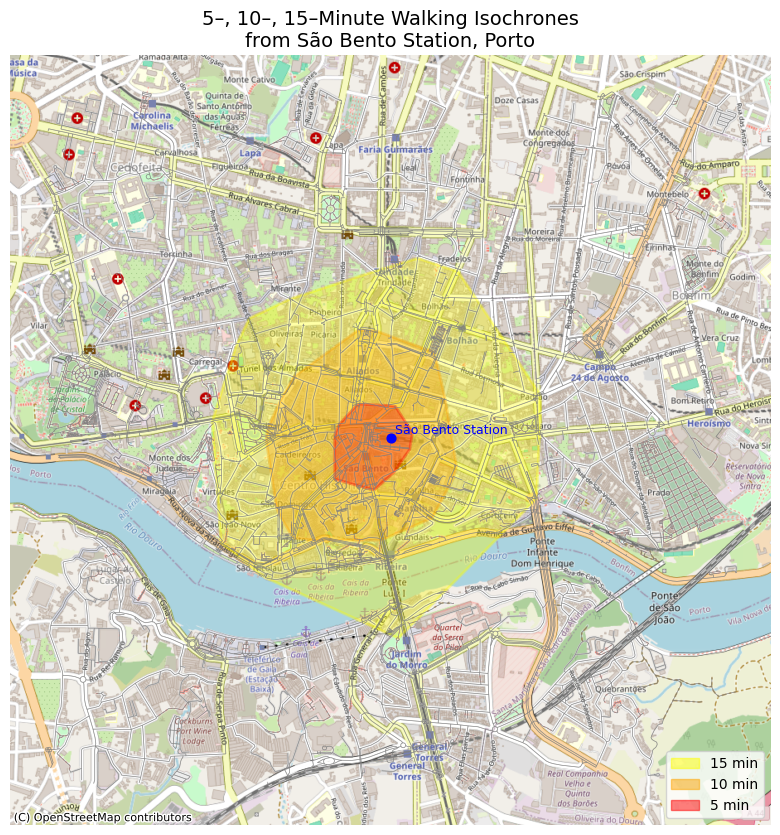

In [7]:
# 5 · Plot the results
colors = ["yellow", "orange", "red"]  # 15, 10, 5 min
fig, ax = plt.subplots(figsize=(10, 10))

# Plot network background
gdf_edges.plot(ax=ax, linewidth=0.5, edgecolor="gray", alpha=0.6)

# Plot isochrones from largest to smallest
for c, mins in zip(colors, sorted(iso_times, reverse=True)):
    gdf_iso[gdf_iso.time == mins].plot(
        ax=ax, color=c, alpha=0.35, edgecolor=c, linewidth=2, label=f"{mins} min")

# Add Trindade point
gdf_trindade.plot(ax=ax, color="blue", markersize=40, zorder=5)
ax.annotate("São Bento Station",
            xy=(gdf_trindade.geometry.x.iloc[0], gdf_trindade.geometry.y.iloc[0]),
            xytext=(3, 3), textcoords="offset points",
            fontsize=9, color="blue")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("5–, 10–, 15–Minute Walking Isochrones\nfrom São Bento Station, Porto", fontsize=14)
ax.axis("off")
handles = [mpatches.Patch(color=c, alpha=0.5, label=f"{t} min") for c, t in zip(colors, sorted(iso_times, reverse=True))]
ax.legend(handles=handles, loc="lower right")
plt.show()

## Summary
In this episode, you learned how to compute and visualize **walk-time isochrones** using `OSMnx`, `NetworkX`, and `GeoPandas`.

You geocoded São Bento Station in Porto, downloaded the surrounding pedestrian network from OpenStreetMap, and calculated travel times assuming a walking speed of 4 km/h.  
Using `ego_graph`, you generated 5-, 10-, and 15-minute isochrone polygons and visualized them on a city map with a clear color scale and OpenStreetMap basemap.